In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from src.config import *
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
perturbations = ['cp', 'lig', 'oe', 'sh', 'xpr']

In [5]:
# read in data
data = pd.read_csv(f'data/lincs_consensus/lm_all_pert_cell_liana.csv', index_col = 0)
meta = pd.read_csv(f'data/design_matrices/all_pert_binary_liana.csv', index_col = 0)
meta.index = meta.index.str.split('_', expand = True)

In [6]:
# count receptors
pert_type_receptor_count = pd.Series(index = perturbations, name = 'receptor_count', dtype= 'int')
for pert in perturbations:
    pert_type_receptor_count[pert] = (meta.iloc[meta.index.get_level_values(2) == pert].abs().sum() != 0).sum()
pert_type_receptor_count = pert_type_receptor_count.sort_values()

In [7]:
pert_type_receptor_count

lig    220.0
oe     223.0
sh     284.0
cp     345.0
xpr    353.0
Name: receptor_count, dtype: float64

In [8]:
name_map_en = {'cp':'Drug\ntreatment', 
               'lig':'Ligand\nstimulation', 
               'oe':'Overexpression', 
               'sh':'shRNA', 
               'xpr':'CRISPR', 
               'total':'Total'}

In [9]:
pert_type_receptor_count['total'] = len(meta.columns[meta.abs().sum() > 0])

In [16]:
# pert_type_receptor_count.to_csv(f'results/qc/pert_type_receptor_count_barplot.csv')

In [29]:
# pert_type_receptor_count = pd.read_csv('results/qc/pert_type_receptor_count_barplot.csv', index_col = 0)

/var/folders/ld/gy00m33j1pn81v2x1sj_h3pm0000gn/T/ipykernel_6683/4267155341.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x = pert_type_receptor_count.index, y = pert_type_receptor_count, palette ='Blues')
/var/folders/ld/gy00m33j1pn81v2x1sj_h3pm0000gn/T/ipykernel_6683/4267155341.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(pert_type_receptor_count.index.map(name_map_en))


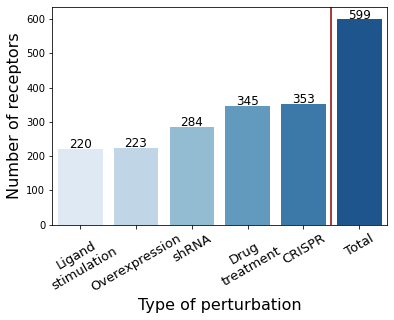

In [10]:
# plot barplot
fig, ax = plt.subplots()
g = sns.barplot(x = pert_type_receptor_count.index, y = pert_type_receptor_count, palette ='Blues')
ax.set_xticklabels(pert_type_receptor_count.index.map(name_map_en))
plt.xticks(rotation = 30)
plt.ylabel('Number of receptors', fontsize =16)
for x, y, p in zip([0,1,2,3,4, 5],pert_type_receptor_count.values+3,pert_type_receptor_count.values):
   plt.text(x, y, int(p), ha = 'center', fontsize = 12)
plt.ylim(0, 635)
plt.xlabel('Type of perturbation', fontsize =16)
plt.xticks(fontsize =13)

plt.axvline(4.5, color = 'darkred')
plt.show()

In [11]:
# read in data
data = pd.read_csv(f'data/lincs_consensus/high_quality/lm_all_pert_cell_liana.csv', index_col = 0)
meta = pd.read_csv(f'data/design_matrices/high_quality/all_pert_binary_liana.csv', index_col = 0)
meta.index = meta.index.str.split('_', expand = True)

In [12]:
confidence_scores = pd.read_csv(f'results/confidence/receptor_rocauc_mean_confidence_scores_229_mwup_withna.csv', index_col = 0)


In [124]:
# count receptors with confidence scores
pert_type_receptor_count_hq = pd.Series(name = 'receptor_count', dtype= 'int')
for pert in perturbations:
    for confidence in confidence_scores.Confidence.unique():
        reclist = confidence_scores[confidence_scores['Confidence'] == confidence]['Receptor'].unique()
        pert_type_receptor_count_hq[f'{pert}_{confidence}'] = (meta.iloc[meta.index.get_level_values(2) == pert].loc[:, reclist].abs().sum() != 0).sum()
    for confidence in confidence_scores.Confidence.unique():
        reclist = confidence_scores[confidence_scores['Confidence'] == confidence]['Receptor'].unique()
        pert_type_receptor_count_hq[f'total_{confidence}'] = (meta.loc[:, reclist].abs().sum() != 0).sum()
pert_type_receptor_count_hq = pert_type_receptor_count_hq.sort_values()
pert_type_receptor_count_hq.index = pert_type_receptor_count_hq.index.str.split('_', expand = True)
pert_type_receptor_count_hq = pert_type_receptor_count_hq.sort_index()
pert_type_receptor_count_hq = pert_type_receptor_count_hq.reset_index().rename(columns = {'level_0':'pert_type', 'level_1':'confidence'})

In [120]:
name_map_en['total'] = 'Total'

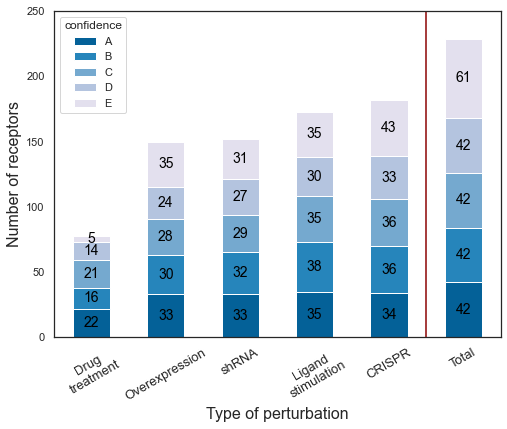

In [133]:
pivot_df = pd.read_csv(f'results/qc/pert_type_receptor_count_hq_with_confidence_barplot.csv')

def gen_colors(df):
    colors = sns.color_palette("PuBu_r", n_colors=df.shape[1])
    return colors

fig, ax = plt.subplots()

pivot_df = pert_type_receptor_count_hq.pivot_table(index='pert_type', columns='confidence', values='receptor_count', aggfunc='sum', fill_value=0)
ordered_categories = ['cp', 'oe', 'sh', 'lig', 'xpr', 'total']
pivot_df.index = pd.Categorical(pivot_df.index, categories=ordered_categories, ordered=True)

pivot_df = pivot_df.sort_index()
pivot_df.plot(kind='bar', stacked=True, figsize=(8, 6), color=gen_colors(pivot_df), ax = ax)
ax.set_xticklabels(pivot_df.index.map(name_map_en))

sns.set_style("white") 
ax.grid(False)  # Disable gridlines
fig.patch.set_facecolor('white')  # Set the figure background color to white
ax.set_facecolor('white') 
# Annotate the stacked bars with their corresponding values
for p in ax.patches:
    height = p.get_height()  # Get the height (value) of the bar segment
    x_position = p.get_x() + p.get_width() / 2  # Get the x-position (center of the segment)
    y_position = p.get_y() + height / 2  # Get the y-position (center of the segment)
    
    ax.annotate(f'{int(height)}', (x_position, y_position), ha='center', va='center', fontsize=14, color='black')

plt.xticks(rotation = 30)

plt.axvline(4.5, color = 'darkred')
plt.xlabel('Type of perturbation', fontsize =16)
plt.ylabel('Number of receptors', fontsize =16)
plt.ylim(0, 250)
plt.xticks(fontsize =13)
plt.show()

In [134]:
# pivot_df.to_csv(f'results/qc/pert_type_receptor_count_hq_with_confidence_barplot.csv')


/var/folders/ld/gy00m33j1pn81v2x1sj_h3pm0000gn/T/ipykernel_6683/81828629.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x = pert_type_receptor_count_hq.index, y = pert_type_receptor_count_hq, palette ='Blues')
/var/folders/ld/gy00m33j1pn81v2x1sj_h3pm0000gn/T/ipykernel_6683/81828629.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(pert_type_receptor_count_hq.index.map(name_map_en))


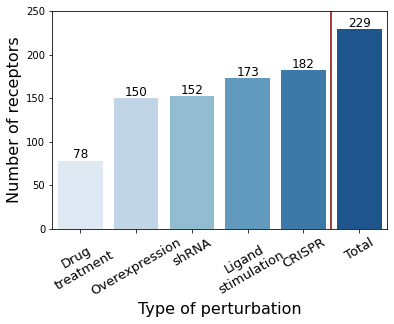

In [15]:
# plot barplot
fig, ax = plt.subplots()
g = sns.barplot(x = pert_type_receptor_count_hq.index, y = pert_type_receptor_count_hq, palette ='Blues')
ax.set_xticklabels(pert_type_receptor_count_hq.index.map(name_map_en))
plt.xticks(rotation = 30)
plt.ylabel('Number of receptors', fontsize =16)
for x, y, p in zip([0,1,2,3,4, 5],pert_type_receptor_count_hq.values+3,pert_type_receptor_count_hq.values):
   plt.text(x, y, int(p), ha = 'center', fontsize = 12)
plt.ylim(0, 250)
plt.xlabel('Type of perturbation', fontsize =16)
plt.xticks(fontsize =13)

plt.axvline(4.5, color = 'darkred')
plt.show()

In [23]:
# pert_type_receptor_count_hq.to_csv(f'results/qc/pert_type_receptor_count_hq_barplot.csv')